# Modeling
Goal: Build two to three different models and identify the best one. 

STEPS:

● Fit your models with a training dataset

● Review model outcomes — Iterate over additional models as needed

● Identify the final model that you think is the best model for this project

In [13]:
#imports
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV, learning_curve, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import cross_val_score
import datetime
from pandas_profiling import ProfileReport
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
from xgboost import XGBClassifier

from library.sb_utils import save_file

ModuleNotFoundError: No module named 'library'

In [2]:
#load data
path= '/Users/josephfrasca/Coding_Stuff/Springboard/Capstone_2/data/processed'
os.chdir(path) 
# subset data into 2014-2018 to create model and 2019-2020 to do final predictions of vacancy rates during that time
df = pd.read_csv('VacancyRate_Zillow_2014_2018')
df19_20 = pd.read_csv('VacancyRate_Zillow_2019_2020')

In [3]:
df

,Zipcode,RentPrice,Year,SizeRank,HomePrice,Vacancy_Rate%,State_AL,State_AR,State_AZ,State_CA,...,CountyName_Weber County,CountyName_Weld County,CountyName_Westchester County,CountyName_Will County,CountyName_Williamson County,CountyName_Wilson County,CountyName_Worcester County,CountyName_Yamhill County,CountyName_Yolo County,CountyName_York County
0,10025,3041.83,2014,0.0,968761.75,9.011810,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,60657,1589.42,2014,1.0,450755.75,8.042922,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10023,3186.67,2014,2.0,1024543.17,19.964756,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,77494,1807.33,2014,3.0,322032.00,3.319292,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,60614,1786.25,2014,4.0,580250.92,8.468203,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16143,2110,4643.58,2018,14752.0,1363870.08,17.412045,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16144,20004,2432.25,2018,15149.0,480942.83,21.036585,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16145,80951,1537.18,2018,15318.0,276619.83,1.084746,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16146,11964,20122.17,2018,17169.0,1000069.25,62.044105,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
#add leading zeros to zipcode
df['Zipcode'] = df['Zipcode'].apply(lambda x: '{0:0>5}'.format(x))
df19_20['Zipcode'] = df19_20['Zipcode'].apply(lambda x: '{0:0>5}'.format(x))

In [5]:
df.Zipcode = df.Zipcode.astype('int')
df19_20.Zipcode = df19_20.Zipcode.astype('int')
df.dtypes

Zipcode                          int64
RentPrice                      float64
Year                             int64
SizeRank                       float64
HomePrice                      float64
                                ...   
CountyName_Wilson County         int64
CountyName_Worcester County      int64
CountyName_Yamhill County        int64
CountyName_Yolo County           int64
CountyName_York County           int64
Length: 1754, dtype: object

In [6]:
#not currently using in this model
'''
#change National ('NATNL') zipcode to '99999' for later modeling
df.Zipcode.replace('NATNL', '99999', inplace=True)
df.Zipcode = df.Zipcode.astype('int')
df.dtypes
'''

"\n#change National ('NATNL') zipcode to '99999' for later modeling\ndf.Zipcode.replace('NATNL', '99999', inplace=True)\ndf.Zipcode = df.Zipcode.astype('int')\ndf.dtypes\n"

In [7]:
#define variable X, y
X = df.drop('Vacancy_Rate%', axis=1)
y = df['Vacancy_Rate%']

In [8]:
#train test split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

tss = TimeSeriesSplit(n_splits = 5)
for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [9]:
#scale the data
#decided not to use scaled data because variables were in the similar format
#and scaled data provided -4 or so results for r^2 scores

scaler = StandardScaler()
#fit the scaler on the training set
scaler.fit(X_train)
#apply the scaling to both the train and test split
X_tr_scaled = scaler.transform(X_train)
X_te_scaled = scaler.transform(X_test)

## Fit your models with a training dataset
Hint: Try a number of different models: you will want to compare their outputs in the
model evaluation stage. For example, if you’re writing a classification model, you should
implement both an entropy model and a Gini impurity model. For hyperparameter tuning,
think of methods like cross-validation . <https://scikit-learn.org/stable/modules/cross_validation.html>

#### Initial Model: Train the model on the train split

In [32]:
lm = LinearRegression().fit(X_train, y_train)

In [33]:
#Make predictions using the model on both train and test splits
y_tr_pred = lm.predict(X_train)
y_te_pred = lm.predict(X_test)

In [34]:
#Assess model performance
# r^2 - train, test
r2 = r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)
print('r2:', r2)

r2: (0.7703801642196972, 0.7437511996458208)


**This is markedly better performance than when using Dummy variable/mean for R^2 (see preprocessing notebook):**

Dummy R2 = (0.0, -0.0003615371793730393)

In [35]:
#MAE - train, test
mae = mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)
print('mae:', mae)

mae: (2.1220824261243973, 2.437957894025986)


In [36]:
# MSE - train, test
mse = mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)
print('mse:', mse) 

mse: (12.635092088166239, 15.074358899362807)


**This is markedly better performance than when using Dummy variable/mean for R^2 (see earlier):**

Dummy -

MAEs: 5.074338214794146 5.188601429791711

MSEs: 55.026135025439736 58.8483100007387

**MSE still high (possibly due to this being a large data set**

In [37]:
#calculate adjusted r2 for training set
#12918 = n , 1754 = p (X_train + y_train) (when using traintest split)
#13457 = n , 1754 = p (X_train + y_train) (when using TimeSeriestraintest split)
Adj_r2Train = 1-(1-r2_score(y_train, y_tr_pred))*(13457-1)/(13457-1754-1)
Adj_r2Train

0.7359626978072334

In [38]:
#calculate adjusted r2 for test set
#3230 = n , 1754 = p (X_test + y_test) (when using traintest split)
#2691 = n , 1754 = p (X_train + y_train) (when using TimeSeriestraintest split)
Adj_r2Test = 1-(1-r2_score(y_test, y_te_pred))*(3230-1)/(3230-1754-1)
Adj_r2Test

0.4390322872246477

### Refining the Linear Model

In [39]:
#Add `SelectKBest` as a step in the pipeline before`LinearRegression()`
#use `f_regression` as its score function
pipe = make_pipeline(
    SelectKBest(f_regression),
    LinearRegression()
)

In [40]:
#fit the pipeline
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('selectkbest',
                 SelectKBest(k=10,
                             score_func=<function f_regression at 0x1a1836c440>)),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [41]:
#assess performance on the train and test set
y_tr_pred = pipe.predict(X_train)
y_te_pred = pipe.predict(X_test)
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.2751230985846814, 0.2481159139680622)

In [42]:
#r2 and mae scores worse when k=10 (default)
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(4.337418529250864, 4.640954642466108)

### Assessing performance using cross-validation

In [43]:
cv_results = cross_validate(pipe, X_train, y_train, cv=5)

In [44]:
cv_scores = cv_results['test_score']
cv_scores

array([0.22309832, 0.2886445 , 0.27456166, 0.28145407, 0.2761517 ])

In [45]:
np.mean(cv_scores), np.std(cv_scores)

(0.2687820495265587, 0.02336585553447227)

###  Hyperparameter search using RandomizedSearchCV
Pulling the above together, we have:

a pipeline that:
- selects the k best features
- trains a linear regression model
- a technique (cross-validation) for estimating model performance

In [46]:
#get a dict of available parameters and print their names
#using dict's `keys()` method
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'selectkbest', 'linearregression', 'selectkbest__k', 'selectkbest__score_func', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__normalize'])

In [47]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}

In [48]:
#use RandomizedSearcCV to optimize parameters
lr_rand_cv = RandomizedSearchCV(pipe, param_distributions=grid_params, cv=5, n_jobs=-1)

In [49]:
lr_rand_cv.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('selectkbest',
                                              SelectKBest(k=10,
                                                          score_func=<function f_regression at 0x1a1836c440>)),
                                             ('linearregression',
                                              LinearRegression(copy_X=True,
                                                               fit_intercept=True,
                                                               n_jobs=None,
                                                               normalize=False))],
                                      verbose=False),
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributions={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7,
                                                           8, 9, 10, 11, 12, 13,
            

In [50]:
score_mean = lr_rand_cv.cv_results_['mean_test_score']
score_std = lr_rand_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_rand_cv.cv_results_['param_selectkbest__k']]

In [51]:
#Print the `best_params_` attribute of `lr_rand_cv`
lr_rand_cv.best_params_

{'selectkbest__k': 1715}

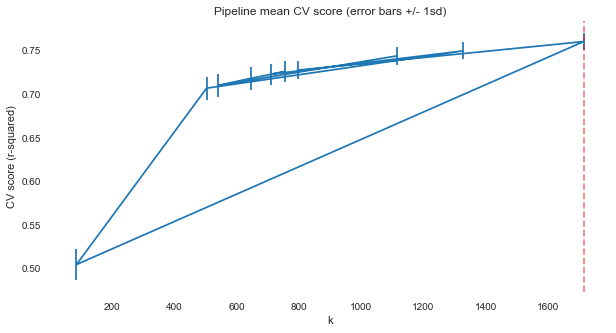

In [52]:
#Assign the value of k from the above dict of `best_params_` and assign it to `best_k`
best_k = lr_rand_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

In [53]:
#get the best estimator, then the named step 'selectkbest'
#for which you can its get_support() method for a logical mask of the features selected.
selected = lr_rand_cv.best_estimator_.named_steps.selectkbest.get_support()

In [54]:
#Get the linear model coefficients from the `coef_` attribute and store in `coefs`,
#get the matching feature names from the column names of the dataframe,
#and display the results as a pandas Series with `coefs` as the values and `features` as the index,
#sorting the values in descending order
coefs = lr_rand_cv.best_estimator_.named_steps.linearregression.coef_
features = X_train.columns[selected]
pd.Series(coefs, index=features).sort_values(ascending=False)

City_Honolulu                    91.712874
City_Waianae                     91.683628
City_Kapolei                     86.394650
City_Wahiawa                     84.256396
City_Ewa Beach                   83.709527
                                   ...    
State_PA                        -74.616501
Metro_Boston-Cambridge-Newton   -84.737310
State_NY                        -89.439315
State_NJ                        -94.812826
State_CT                        -95.523682
Length: 1715, dtype: float64

These results suggested that Cities (in Hawaii), States (in the northeast - PA, NY, NJ, CT), and Metro Boston, Cambridge, Newton are the features with greatest importance in the model. Wonder why this may be? Further exploration of these variables is needed.

## Review model outcomes — Iterate over additional models as needed 
Hint: you may want to use standard model evaluation metrics such as accuracy, recall,
precision, and F1.

### Random Forest Model

In [13]:
#Define a RandomForestRegressor()
RF_pipe = RandomForestRegressor()

In [19]:
#Call `cross_validate` to estimate the pipeline's performance.
#Pass it the random forest pipe object, `X_train` and `y_train`,
#and get it to use 5-fold cross-validation
rf_default_cv_results = cross_validate(RF_pipe, X_train, y_train, cv=5)

In [20]:
rf_cv_scores = rf_default_cv_results['test_score']
rf_cv_scores

array([0.89647488, 0.9452659 , 0.96456754, 0.95530373, 0.92440334])

In [21]:
np.mean(rf_cv_scores), np.std(rf_cv_scores)

(0.9372030787704777, 0.024347795621336786)

In [14]:
#assess performance on the train and test set
RF_pipe.fit(X_train, y_train)
y_tr_pred = RF_pipe.predict(X_train)
y_te_pred = RF_pipe.predict(X_test)
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.9913348658246198, 0.921966470384737)

In [15]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(0.45649268563334405, 1.4596099192345455)

In [16]:
#calculate adjusted r2 for training set
#12918 = n , 1754 = p (X_train + y_train) (when using traintestsplit)
#13457 = n , 1754 = p (X_train + y_train) (when using TimeSeriestraintest split)
Adj_r2Train = 1-(1-r2_score(y_train, y_tr_pred))*(13457-1)/(13457-1754-1)
Adj_r2Train

0.9898295299240707

In [17]:
#calculate adjusted r2 for test set
#3230 = n , 1754 = p (X_test + y_test) (when using traintestsplit)
#2691 = n , 1754 = p (X_train + y_train) (when using TimeSeriestraintest split)
Adj_r2Test = 1-(1-r2_score(y_test, y_te_pred))*(2691-1)/(2691-1754-1)
Adj_r2Test

0.7764337959551368

#### Hyperparameter search using RandomizedSearchCV

In [15]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params = {
        'randomforestregressor__n_estimators': n_est,
}
grid_params

{'randomforestregressor__n_estimators': [10,
  12,
  16,
  20,
  26,
  33,
  42,
  54,
  69,
  88,
  112,
  143,
  183,
  233,
  297,
  379,
  483,
  615,
  784,
  1000]}

In [16]:
#Call `RandomizedSearchCV` with the random forest pipeline, passing in the above `grid_params`
#dict for parameters to evaluate, 5-fold cross-validation, and all available CPU cores
rf_rand_cv = RandomizedSearchCV(RF_pipe, param_distributions=grid_params, cv=5, n_jobs=-1)

In [19]:
rf_rand_cv.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__bootstrap', 'estimator__ccp_alpha', 'estimator__criterion', 'estimator__max_depth', 'estimator__max_features', 'estimator__max_leaf_nodes', 'estimator__max_samples', 'estimator__min_impurity_decrease', 'estimator__min_impurity_split', 'estimator__min_samples_leaf', 'estimator__min_samples_split', 'estimator__min_weight_fraction_leaf', 'estimator__n_estimators', 'estimator__n_jobs', 'estimator__oob_score', 'estimator__random_state', 'estimator__verbose', 'estimator__warm_start', 'estimator', 'iid', 'n_iter', 'n_jobs', 'param_distributions', 'pre_dispatch', 'random_state', 'refit', 'return_train_score', 'scoring', 'verbose'])

In [17]:
#call the `RandomizdSearchCV`'s `fit()` method with `X_train` and `y_train` as arguments
rf_rand_cv.fit(X_train, y_train)

ValueError: Invalid parameter randomforestregressor for estimator RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False). Check the list of available parameters with `estimator.get_params().keys()`.

In [ ]:
#Print the best params (`best_params_` attribute) from the grid search
rf_rand_cv.best_params_

In [ ]:
rf_best_cv_results = cross_validate(rf_rand_cv.best_estimator_, X_train, y_train, cv=5)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

In [ ]:
np.mean(rf_best_scores), np.std(rf_best_scores)

In [ ]:
#Plot a barplot of the random forest's feature importances,
#assigning the `feature_importances_` attribute of 
#`rf_grid_cv.best_estimator_.named_steps.randomforestregressor` to the name `imps` to then
#create a pandas Series object of the feature importances, with the index given by the
#training data column names, sorting the values in descending order
plt.subplots(figsize=(16, 8))
imps = rf_rand_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');

In [ ]:
#assess performance on the train and test set
y_tr_pred = rf_rand_cv.predict(X_train)
y_te_pred = rf_rand_cv.predict(X_test)
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

In [ ]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

In [ ]:
#Try adjusted r2 as well



### XGBoost Model

Note: model took several days of running and still did not load so abandoned this model

In [28]:
# fit XGBoost Model to training data
from time import time
rows = 500
t = time()
model = XGBClassifier()
model.fit(X_train.head(rows), y_train.head(rows))
print('model fitting for XGB classifier, on {} rows. Took {} seconds'.format(rows, time()-t))

model fitting for XGB classifier, on 500 rows. Took 2876.103660106659 seconds


In [29]:
#evaluate XGBoost model performance
y_tr_pred = model.predict(X_train)
y_te_pred = model.predict(X_test)
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(-1.1241648075550614, -1.012896537964152)

In [30]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(7.873536114623062, 7.732314809746003)

In [31]:
#calculate adjusted r2 for training set
#12918 = n , 1754 = p (X_train + y_train)
Adj_r2Train = 1-(1-r2_score(y_train, y_tr_pred))*(12918-1)/(12918-1754-1)
Adj_r2Train

-1.4579267955915727

In [32]:
#calculate adjusted r2 for test set
#3230 = n , 1754 = p (X_test + y_test)
Adj_r2Test = 1-(1-r2_score(y_test, y_te_pred))*(3230-1)/(3230-1754-1)
Adj_r2Test

-3.4065375736177943

### Lasso (to create feature selector) Model

In [14]:
# Instantiate a lasso regressor: lasso
lasso = Lasso(alpha=0.4, normalize=True)

# Fit the regressor to the data
lasso.fit(X_train, y_train)

# Compute and print the coefficients
lasso_coef = lasso.fit(X_train, y_train).coef_
print(lasso_coef)

[-0.  0. -0. ... -0. -0. -0.]


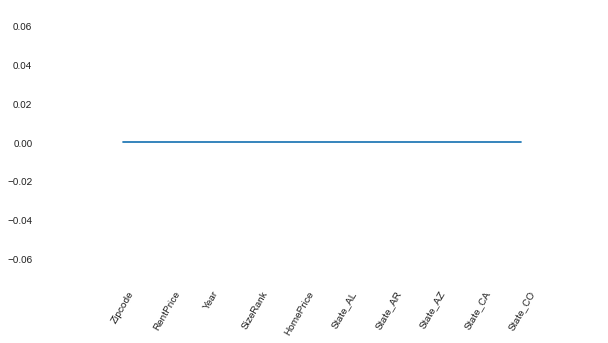

In [17]:
# Plot the coefficients
plt.subplots(figsize=(10, 5))
plt.plot(range(len(X_train.columns[:10])), lasso_coef[:10])
plt.xticks(range(len(X_train.columns[:10])), X_train.columns[:10].values, rotation=60)
plt.margins(0.2)
plt.show()

It seems from this that the top 10 features in predicting vacacny rate comprise:
 - zipcode
 - rent price
 - year
 - size rank
 - home price
 - State

### Ridge Regression Model

In [56]:
#define function to fit ridge regression models over a range of different alphas

def display_plot(cv_scores, cv_scores_std):
    '''plots the R2 score as well as standard error for each alpha'''
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(alpha_space, cv_scores)

    std_error = cv_scores_std / np.sqrt(10)

    ax.fill_between(alpha_space, cv_scores + std_error, cv_scores - std_error, alpha=0.2)
    ax.set_ylabel('CV Score +/- Std Error')
    ax.set_xlabel('Alpha')
    ax.axhline(np.max(cv_scores), linestyle='--', color='.5')
    ax.set_xlim([alpha_space[0], alpha_space[-1]])
    ax.set_xscale('log')
    plt.show()

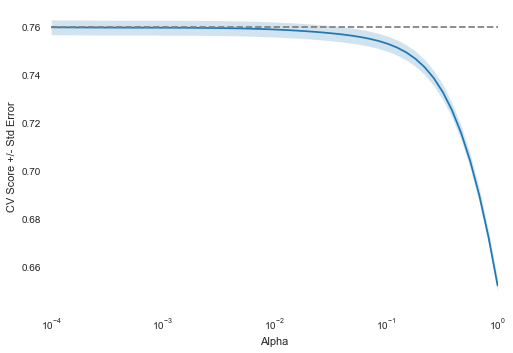

In [57]:
# Setup the array of alphas and lists to store scores
alpha_space = np.logspace(-4, 0, 50)
ridge_scores = []
ridge_scores_std = []

# Create a ridge regressor: ridge
ridge = Ridge(normalize=True)

# Compute scores over range of alphas
for alpha in alpha_space:

    # Specify the alpha value to use: ridge.alpha
    ridge.alpha = alpha
    
    # Perform 5-fold CV: ridge_cv_scores
    ridge_cv_scores = cross_val_score(ridge, X_train, y_train, cv=5)
    
    # Append the mean of ridge_cv_scores to ridge_scores
    ridge_scores.append(np.mean(ridge_cv_scores))
    
    # Append the std of ridge_cv_scores to ridge_scores_std
    ridge_scores_std.append(np.std(ridge_cv_scores))

# Display the plot
display_plot(ridge_scores, ridge_scores_std)


In [ ]:
## NEED TO FIT PREDICT THE RIDGE REGRESSOR....
##create function to score (r2, adjusted r2, mae, rmse)... also could have function fit and train a model...

## Identify the final model that you think is the best model for this project
Hint: the most powerful model isn’t always the best one to use. Other considerations
include computational complexity, scalability, and maintenance costs.


### Linear regression model performance

In [44]:
# 'neg_mean_absolute_error' uses the (negative of) the mean absolute error
lr_neg_mae = cross_validate(lr_rand_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [45]:
lr_mae_mean = np.mean(-1 * lr_neg_mae['test_score'])
lr_mae_std = np.std(-1 * lr_neg_mae['test_score'])
lr_mae_mean, lr_mae_std

(2.721863024637768, 0.06847383890420836)

In [1]:
mean_absolute_error(y_test, lr_rand_cv.best_estimator_.predict(X_test))

NameError: name 'mean_absolute_error' is not defined

### Random forest regression model performance

In [47]:
rf_neg_mae = cross_validate(rf_rand_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [48]:
rf_mae_mean = np.mean(-1 * rf_neg_mae['test_score'])
rf_mae_std = np.std(-1 * rf_neg_mae['test_score'])
rf_mae_mean, rf_mae_std

(1.52195694813689, 0.025506237478906745)

In [50]:
### Check model performance WITH ROOT MEAN SQUARED ERROR ‘neg_root_mean_squared_error’
#https://scikit-learn.org/stable/modules/model_evaluation.html#scoring
rf_neg_rmse = cross_validate(rf_rand_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)

In [51]:
rf_rmse_mean = np.mean(-1 * rf_neg_rmse['test_score'])
rf_rmse_std = np.std(-1 * rf_neg_rmse['test_score'])
rf_rmse_mean, rf_rmse_std

(2.343927493930541, 0.08219130910639365)

#### Conclusion

**Concluded that it seemed the best model was the out of the box random forest regression, as this had the highest performance and took less long to run compared to the models where hyperparamters were optimized**

## Data quantity assessment 
check if we need to undertake further data collection. Would more data be useful? 

Assess this trade off by seeing how performance varies with differing data set sizes. 
The learning_curve function does this conveniently.

In [60]:
fractions = [.2, .25, .3, .35, .4, .45, .5, .6, .75, .8, 1.0]
train_size, train_scores, test_scores = learning_curve(pipe, X_train, y_train, train_sizes=fractions)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divid

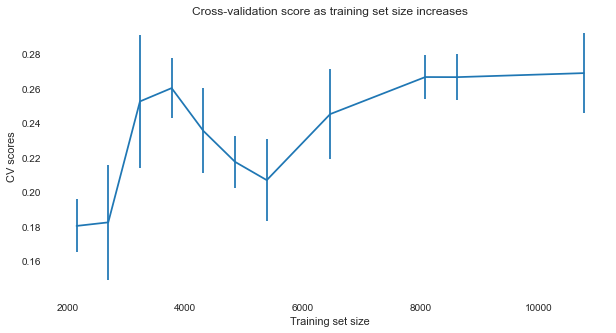

In [61]:
#seems we have enough data
plt.subplots(figsize=(10, 5))
plt.errorbar(train_size, test_scores_mean, yerr=test_scores_std)
plt.xlabel('Training set size')
plt.ylabel('CV scores')
plt.title('Cross-validation score as training set size increases');

## Save best model object from pipeline

In [27]:
# save the model to disk
os.chdir('/Users/josephfrasca/Coding_Stuff/Springboard/Capstone_2/models')
filename = 'random_forest_model.sav'
pickle.dump(RF_pipe, open(filename, 'wb'))

In [12]:
#load model
path= '/Users/josephfrasca/Coding_Stuff/Springboard/Capstone_2/models'
os.chdir(path)
filename = 'random_forest_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
#test it worked
result = loaded_model.score(X_test, y_test)
print(result)

0.922208934205951


In [15]:
#save model is pickle format (smaller size)
with open('random_forest_model.pkl', 'wb') as f:
    pickle.dump(loaded_model, f)

## Reflection
Review the following questions and apply them to your analysis:
    
● Does my data involve a time series or forecasting? If so, am I splitting the train and test data appropriately? **yes did time series split**

● Is my response variable continuous or categorical? **some of both**

## Summary
- loaded data and added leading zeros to zipcode as these were dropped from pd.read_csv, changed zipcode to 'int' in preparation for modeling
    - data was subset into 2014-2018 to create model and 2019-2020 to do final predictions of vacancy rates during that time
- decided not to include national data for this model
- defined X, y variables and did TimeSeriesSlit using 5 = n_splits for the 5 years from 2014-2018
- decided not to use scaled data because variables were in the similar format and scaled data provided -4 or so results for r^2 scores (possibly because dummy variables had been created before the scaling

Fit your models with a training dataset

Linear Regression Model
- trained linear regression model on training data
- Made predictions using the model on both train and test splits. 
- Assessed model performance, r^2 - train: 0.7703801642196972, test: 0.7437511996458208
    - as noted previously this was better performance than the dummy variable/mean in preprocessing notebook 4.2
- Assessed mode performance using adjusted r2 for training/testing sets (because data set is rather large)
    - adjusted r2 for train set: 0.7359626978072334
    - adjusted r2 for test set: 0.4390322872246477
- it seems the model is not performing that well when looking at adjusted r2 test performance vs. r2 test performance
- Refining the Linear Model
    - Added `SelectKBest` as a step in the pipeline before`LinearRegression()` and used `f_regression` as its score function
    - Fit the pipeline and assessed R2 performance on the train 0.2751230985846814 and test set 0.2481159139680622
    - r2 and mae scores worse when k=10 (default)
- Assessing performance using cross-validation
    - cross validation score mean: 0.2687820495265587, std: 0.02336585553447227
    - **model seems to perform worst after selected k=10 hyperparameter tuning**
- Hyperparameter search using RandomizedSearchCV
    - made a pipeline that:
        - selects the k best features
        - trains a linear regression model
        - uses cross-validation for estimating model performance
    - used RandomizedSearcCV to optimize parameters
    - found {'selectkbest__k': 1715}
    - plotted k vs. cv scores, **seemed like best CV score approached 75% with k=1715** (for reference there are 1754 total variables)
    - inspected feature importance with: `coefs` as the values and `features` as the index,
        - results suggested that Cities (in Hawaii), States (in the northeast - PA, NY, NJ, CT), and Metro Boston, Cambridge, Newton are the features with greatest importance in the model. Wonder why this may be? Further exploration of these variables is needed.
        
Random Forest Model
- used 5 fold cross validation on training data with of the box random forrest regressor and found mean cross validation score of 0.9366068391290183 and std of 0.023896683225663608
- assessed R2 performance on the train/test set
    - TRAIN 0.9912288875500109, TEST 0.9217952943465487
    - mean absolute error, TRAIN: 0.45897055621241456, TEST: 1.4643096841878729
- assessed Adjusted R2 performance 
    - TRAIN: 0.9899141950839982
    - TEST: 0.7752450232822821
- **Model had significantly improved peformance on random forest test data R2: .92. However Adjusted R2 on test data showed score of .78 which seems to suggest some of performance is skewed by the large number of variables**
- Hyperparameter search using RandomizedSearchCV
    - searched for 'randomforestregressor__n_estimators'
    - found the best {'randomforestregressor__n_estimators': 615}
    - ran the model with the optimized n_estimators, not much difference in performance was noted. Since this took so long to load decided to use out of the box random forest model. And did not do further testing with these hyperparameters
    - tried to see feature importance on graph, but couldn't see it visualized.. WILL REVISIT HERE
    
XG Boost Model
- took several days of running and still did not load so tried data in smaller chunks..
- model fitting for XGB classifier, on 100 rows. Took 80.19277906417847 seconds
    - R2: -0.7574101368649369
    - MAE: 6.759850692988607)
    - adjusted R2: -2.85
- model fitting for XGB classifier, on 200 rows. Took 304.025593996048 seconds
    - R2: -0.9636404804460941
    - MAE: 7.548588382040348
    - adjusted R2: -3.3
- model fitting for XGB classifier, on 500 rows. Took 2876.103660106659 seconds

Lasso Model (to create feature selector)
    - It seems from this that the top 10 features in predicting vacacny rate comprise:
         - zipcode
         - rent price
         - year
         - size rank
         - home price
         - State(s)

Ridge Regression Model
    - defined function to fit ridge regression models over a range of different alphas
    - created ridge regression and computed scores over range of alphas, peforming 5-fold CV
    - **looks like CV scores maxes out around .76 with an Alpha of 10^-4. Want to run again with smaller alphas to see if there is better performance**
    
**Concluded that it seemed the best model was the out of the box random forest regression, as this had the highest performance and took less long to run compared to the models where hyperparamters were optimized. Want to run this model again but with only the most important features**

- performed Data quantity assessment to check if we need to undertake further data collection. Does not seem that more data be useful.
- saved the random forrest regression model